## <center> SUNSPOT DATA AND FLARE OCCURENCES ANALYSIS </center>

* Sunspots are phenomena on the Sun's photosphere that appear as temporary spots that are darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic flux that inhibit convection. (Wikipedia)

<br>

This analysis wants to discover hidden correlation between sunspot data and solar flare occurences, so as to enable researchers identify key factors to consider when predicting the occurences of solar flares

In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell

#auto print items
InteractiveShell.ast_node_interactivity = "all"

#setting params
sns.set_style("darkgrid")

from prettytable import PrettyTable
import json

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
#load the two text data for wrangling

# specify the columns using the reference provided in the website below

#https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/sunspot-regions/usaf_mwl/documentation/usaf_sunspot-region-reports_format.txt

# mc - (Mt Wilson) magnetic classification
# mwil - max magnetic field strength
# sp - Mount Wilson spot group
# class - McIntosh Classification
# ns - Number of spots (USAF only)
# lg - Longitudinal extent in degrees (USAF only)
# solar area - Area in millionths of solar hemisphere (USAF only)
# serial - Station serial number
# icmp - Individual Central Meridian Passage date
# rcmp - Regional Central Meridian Passage date
# serial - Station serial number
# quality - Quality (1=very poor, 2=poor, 3=fair, 4=good, 5=excellent)
# abbrev - 4-letter station abbreviation

columns1 = ["date", "time", "location", "mc", "mwil", "sp", "NOAA Number", "class", "ns", "lg", "solar area", "icmp", "rcmp", "serial", "quality", "abbrev"]
data1 = pd.read_csv("sunspots1981-2017.txt", sep=",", names=columns1, dtype="object")


# specify the columns using the reference provided in the website below under output specification section
# https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-flares/x-rays/goes/documentation/miscellaneous/software/xraydatareports.proc


columns2 = ["date", "start time", "end time", "average time", "location", "flare type", "satellite", "NOAA Number", "magnitude"]
data2 = pd.read_csv("flares1981-2017.txt", sep=",", names=columns2, dtype="object")

In [3]:
#preview the datasets
data1.head()

,date,time,location,mc,mwil,sp,NOAA Number,class,ns,lg,solar area,icmp,rcmp,serial,quality,abbrev
0,811201,0021,N13W46,BG,NaN,NaN,3478,EKI,32,12,600,811127.5,811127.5,938,4,LEAR
1,811201,0115,N13W46,NaN,NaN,NaN,3478,EHI,16,11,530,811127.6,811127.5,205,2,MANI
2,811201,0210,N12W47,BG,NaN,NaN,3478,EHO,22,14,710,811127.5,811127.5,626,2,PALE
3,811201,1355,N15W56,BG,NaN,NaN,3478,EHI,31,13,670,811127.3,811127.5,468,2,RAMY
4,811201,1535,N13W55,BG,NaN,NaN,3478,EHI,17,13,430,811127.5,811127.5,624,2,HOLL


In [4]:
data2.head()

,date,start time,end time,average time,location,flare type,satellite,NOAA Number,magnitude
0,810102,0441,0446,0444,NaN,C18,GOES,NaN,NaN
1,810102,0955,1004,1000,NaN,C18,GOES,NaN,NaN
2,810103,1025,1036,1030,NaN,C51,GOES,NaN,NaN
3,810103,1549,1558,1553,NaN,C22,GOES,2857,NaN
4,810103,1837,1845,1842,NaN,C22,GOES,NaN,NaN


In [5]:
#the coursework suggested i should use the following columns of the sunspot data
# date, sunspot number (optionally, location, classification information for visualization)
#so i will filter out those columns and add NOAA for cross referencing purposes
df1 = data1[["date", "ns", "location", "class", "NOAA Number"]].copy()

In [6]:
df1.head()

,date,ns,location,class,NOAA Number
0,811201,32,N13W46,EKI,3478
1,811201,16,N13W46,EHI,3478
2,811201,22,N12W47,EHO,3478
3,811201,31,N15W56,EHI,3478
4,811201,17,N13W55,EHI,3478


In [7]:
# while for flare data, i intend focusing on the following columns for better analysis
# date, location, flare type, NOAA Number
# but before i select the location column, i will strip off the last two values in each row because according the website below
# https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-flares/x-rays/goes/documentation/miscellaneous/software/xraydatareports.pro
# those last two values are not part of the location values, they indicate something else

data2["location"] = data2["location"].apply(lambda x : x if type(x).__name__ == 'float' else x[:-2])
df2 = data2[["date", "flare type", "location", "NOAA Number"]]

In [8]:
df2.head()

,date,flare type,location,NOAA Number
0,810102,C18,NaN,NaN
1,810102,C18,NaN,NaN
2,810103,C51,NaN,NaN
3,810103,C22,NaN,2857
4,810103,C22,NaN,NaN


### <center> EXPLORATORY DATA ANALYSIS </center>

* For this analysis, I will start by checking the nature of missing data, their magnitude in the dataset and proffer likely solutions to them, before i proceed to visualizing the various columns needed for better insight into the data

In [9]:
#Write a function to check for missing data, sum them and load them into tabular form
def missing_data(data):
    
    #Using prettytable to display the sunspot data info in an organized format
    table = PrettyTable(["Index","Columns with missing data", "Sum of missing values"])
    index = 1
    for x in data.columns:
        if data[x].isna().sum() >= 1:
            table.add_row([index, x, data[x].isna().sum()])
            index += 1
    return table

table = missing_data(df1)
print("SUNSPOT DATA MISSING ANALYSIS")
print(table)
print()
print("Total number of rows ->",len(df1))

SUNSPOT DATA MISSING ANALYSIS
+-------+---------------------------+-----------------------+
| Index | Columns with missing data | Sum of missing values |
+-------+---------------------------+-----------------------+
|   1   |            date           |           9           |
|   2   |             ns            |         36854         |
|   3   |          location         |           9           |
|   4   |           class           |         36948         |
|   5   |        NOAA Number        |           46          |
+-------+---------------------------+-----------------------+

Total number of rows -> 271892


* Given the above table, the date column has 9 missing values, the sunspot number has 36,854 missing data, the location has 9 missing data, the classification column has 36,948 missing data which is the highest in the overal missing data analysis for this dataset and NOAA Number has 46 missing data.

* Given the large volumn of the dataset (which is 271,892 rows), dropping the missing data is the more preferred option, because it will provide us with data points that can be useful in this analysis without introducing any correctional bias to the data (i.e. by replacing values, either with the mean of the column or mode of the column, one can introduce a form of biasness into the data)

In [10]:
#data 2
table = missing_data(df2)
print("FLARE DATA MISSING ANALYSIS")
print(table)
print()
print("Total number of rows ->",len(df2))

FLARE DATA MISSING ANALYSIS
+-------+---------------------------+-----------------------+
| Index | Columns with missing data | Sum of missing values |
+-------+---------------------------+-----------------------+
|   1   |            date           |           6           |
|   2   |         flare type        |           33          |
|   3   |          location         |         37305         |
|   4   |        NOAA Number        |         33299         |
+-------+---------------------------+-----------------------+

Total number of rows -> 72054


* Given the above table, the two important column for this analysis has very low missing data which stands at 6 and 33 for date and flare type respectively.
* So therefore, dropping the missing data for flare type and date would not significantly affect the analysis, while the other two columns, i will fill the missing values with zeros (0), since location and NOAA Numbers are treated as objects in this analysis and set aside for use in visualization

In [11]:
# Drop the missing data in the sunspot data
df1.dropna(inplace=True)

#preview the new data
table = missing_data(df1)
print("SUNSPOT MISSING DATA ANALYSIS")
print(table)
print()
print("Total number of rows ->",len(df1))

SUNSPOT MISSING DATA ANALYSIS
+-------+---------------------------+-----------------------+
| Index | Columns with missing data | Sum of missing values |
+-------+---------------------------+-----------------------+
+-------+---------------------------+-----------------------+

Total number of rows -> 234936


* Missing data well handled

In [12]:
# drop the missing data in date and flare type only
df2.dropna(inplace=True)

table = missing_data(df2)
print("FLARES MISSING DATA ANALYSIS")
print(table)
print()
print("Total number of rows ->",len(df2))

FLARES MISSING DATA ANALYSIS
+-------+---------------------------+-----------------------+
| Index | Columns with missing data | Sum of missing values |
+-------+---------------------------+-----------------------+
+-------+---------------------------+-----------------------+

Total number of rows -> 33329


In [13]:
# dealing with the columns datatypes
# At the point of loading the data, i had to enforce OBJECT as the datatype because i observed that 
# the pandas library automatically converts most of the columns to float datatype which is not what is needed
# so i will manually convert the datatypes of the date columns in both date and sunspots number

df1.dtypes

date           object
ns             object
location       object
class          object
NOAA Number    object
dtype: object

In [14]:
df2.dtypes

date           object
flare type     object
location       object
NOAA Number    object
dtype: object

* Before i can convert to datetime, i need to complete the year tag (from 81 to 1981 etc) using a function to do both data

In [15]:
def yearSorter(df):
    """
    A function to add the remaining values for the year date
    """
    store = []
    for val in df:
        if val[0].startswith('0') or val[0].startswith('1'):
            val = "20" + val[:2] + val[2:]
        else:
            val = "19" + val[:2] + val[2:]
        store.append(val)
    return store

In [16]:
#apply the function
df1['date'] = yearSorter(df1['date'])
df2['date'] = yearSorter(df2['date'])

In [17]:
#preview the result
df1

,date,ns,location,class,NOAA Number
0,19811201,32,N13W46,EKI,3478
1,19811201,16,N13W46,EHI,3478
2,19811201,22,N12W47,EHO,3478
3,19811201,31,N15W56,EHI,3478
4,19811201,17,N13W55,EHI,3478
...,...,...,...,...,...
271887,20170629,2,N18W35,CSO,12664
271888,20170629,3,N19W42,CSO,12664
271889,20170630,2,N15W45,CSO,12664
271890,20170630,1,N18W47,HSX,12664


In [18]:
# date data
df1["date"] = pd.to_datetime(df1["date"])
df2["date"] = pd.to_datetime(df2["date"])

In [19]:
df1

,date,ns,location,class,NOAA Number
0,1981-12-01,32,N13W46,EKI,3478
1,1981-12-01,16,N13W46,EHI,3478
2,1981-12-01,22,N12W47,EHO,3478
3,1981-12-01,31,N15W56,EHI,3478
4,1981-12-01,17,N13W55,EHI,3478
...,...,...,...,...,...
271887,2017-06-29,2,N18W35,CSO,12664
271888,2017-06-29,3,N19W42,CSO,12664
271889,2017-06-30,2,N15W45,CSO,12664
271890,2017-06-30,1,N18W47,HSX,12664


In [20]:
# sunspot data
df1['ns'] = df1['ns'].astype("int64")

In [21]:
df1.dtypes

date           datetime64[ns]
ns                      int64
location               object
class                  object
NOAA Number            object
dtype: object

In [22]:
df2.head()

,date,flare type,location,NOAA Number
6,1981-01-03,C12,S05W67,2857
7,1981-01-03,C20,N14W78,2866
11,1981-01-04,C22,N11W86,2872
16,1981-01-05,C18,S14E47,2875
23,1981-01-06,C25,S17E39,2875


In [23]:
# Visualize the unique flare types in the data
#plot the various date details
def plotter(data, col, name, ascend=False):
    
    d = data[col].value_counts().reset_index().sort_values(by=col, ascending=ascend)[:20]
    #fig = plt.figure(figsize=(21, 13))
    if ascend == True:
        dir = "Bottom"
    else:
        dir = "Top"
    title = plt.title(f"{dir} 20 {name.capitalize()} Distribution Plot", fontsize=20)
    plot = plt.scatter(x=d['index'], y=d[col])
    xlabel = plt.xlabel(f"{name.capitalize()}", fontsize=15)
    ylabel = plt.ylabel("Counts", fontsize=15)
    plot0 = plt.plot(d['index'], d[col], "r")
    x = plt.xticks(d['index'], rotation=90)

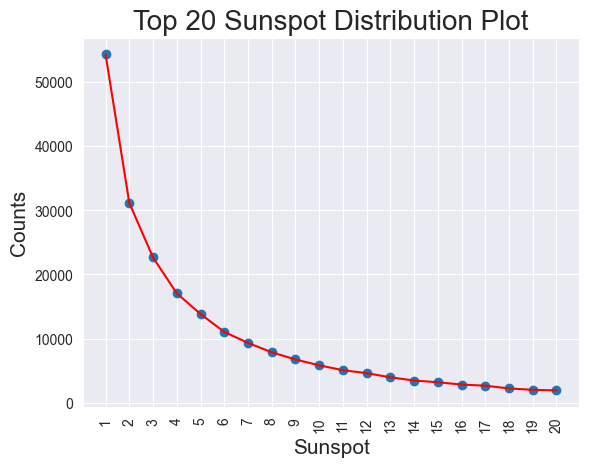

In [24]:
#plot the sunspot data from the first dataframe
plotter(df1, 'ns', name="Sunspot")

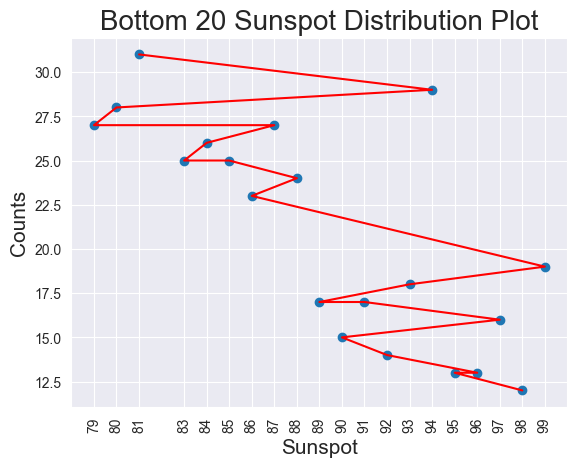

In [25]:
plotter(df1, 'ns', name="Sunspot", ascend=True)

* Sunspot number 1, happens to be the most common in the dataset, while extreme sunspots number 98 has the least occurences across the years in review

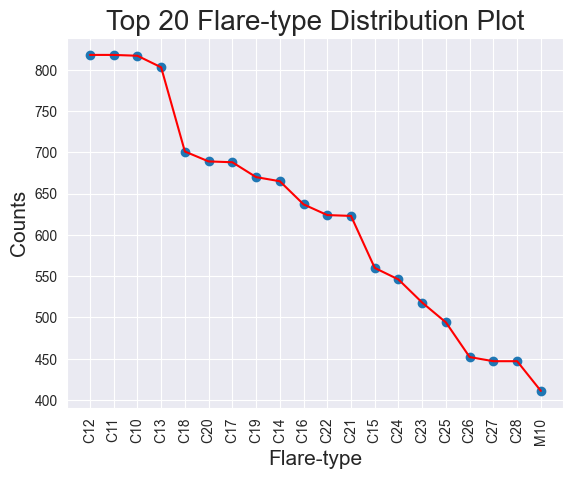

In [26]:
#plot the flares from the second data
plotter(df2, 'flare type', 'flare-type')

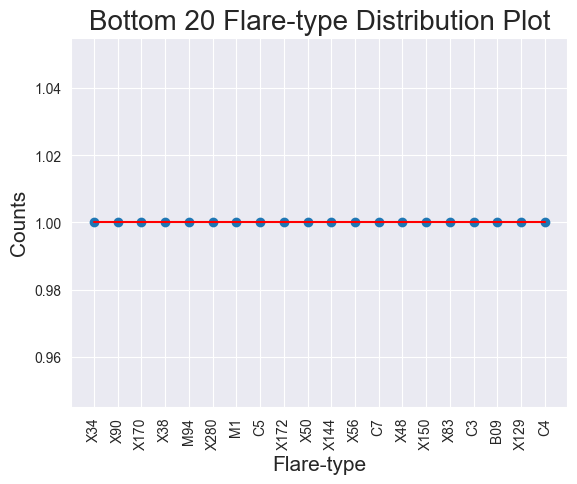

In [27]:
plotter(df2, 'flare type', 'flare-type', ascend=True)

* From the plot c12 flare type which is the C class of flare with 12 x-ray intensity level has the highest occurence across the years in review, while the listed flare type in the image above all had a one-time occurence.

#### Significance of the plots above

While it will be too early to arrive at any conclusion, one notable observation is that there is a sharp L-curve line movement from the sunspot number 1 to higher sunspot numbers, while sun flares type C dominated the first plot, so basically, i am hopeful to generate more answers from further analysis.

* Now i have a well defined datatypes for the columns. going forward, before i will merge, i want to select the solar flares that of importance to this report, which are the X and M class of solar flare, then concatenate them and i will merge the two dataset on the date, since it offers similar ranges even though the flare data has less datapoint to the sunspot data at this junction.

In [28]:
#sort the flares classes that are dangerous to earth
x_flares = df2[df2['flare type'].str.startswith('X')]
m_flares = df2[df2['flare type'].str.startswith('M')]

In [29]:
# concatenate them
flares = pd.concat([m_flares, x_flares])

In [30]:
#preview the new dataset
flares

,date,flare type,location,NOAA Number
116,1981-01-25,M12,N18W26,2907
123,1981-01-25,M24,S13E75,2911
124,1981-01-25,M13,S13E90,2911
132,1981-01-25,M19,S15E95,2911
133,1981-01-26,M26,S14E84,2911
...,...,...,...,...
67916,2014-10-26,X20,S18W,2192
67935,2014-10-27,X20,S17W,2192
68016,2014-11-07,X16,N17E,2205
68318,2014-12-20,X18,S21W,2242


In [31]:
#merge the dataset together
df = pd.merge(df1, flares, on='date')
df.head()

,date,ns,location_x,class,NOAA Number_x,flare type,location_y,NOAA Number_y
0,1981-12-01,32,N13W46,EKI,3478,M24,N15W11,3484
1,1981-12-01,32,N13W46,EKI,3478,M17,N15W13,3484
2,1981-12-01,32,N13W46,EKI,3478,M34,N15W16,3484
3,1981-12-01,32,N13W46,EKI,3478,M21,N16W19,3484
4,1981-12-01,16,N13W46,EHI,3478,M24,N15W11,3484


* After the merging of the datapoints, let's check for missing values

In [32]:
table = missing_data(df)
print("MISSING DATA ANALYSIS")
print(table)
print()
print("Total number of rows ->",len(df))

MISSING DATA ANALYSIS
+-------+---------------------------+-----------------------+
| Index | Columns with missing data | Sum of missing values |
+-------+---------------------------+-----------------------+
+-------+---------------------------+-----------------------+

Total number of rows -> 146174


In [33]:
print("Merged data length ->",len(df))
print("Sunspot data length ->",len(df1))
print("Flares data length ->",len(df2))

Merged data length -> 146174
Sunspot data length -> 234936
Flares data length -> 33329


* Given the length of the merged dataset, i discovered that there are some dates with multiple solar flares unlike that of Sunspot, so the pandas merging algorithm will repeat those rows with all the flare data to reflect a true merging of the two dataset.

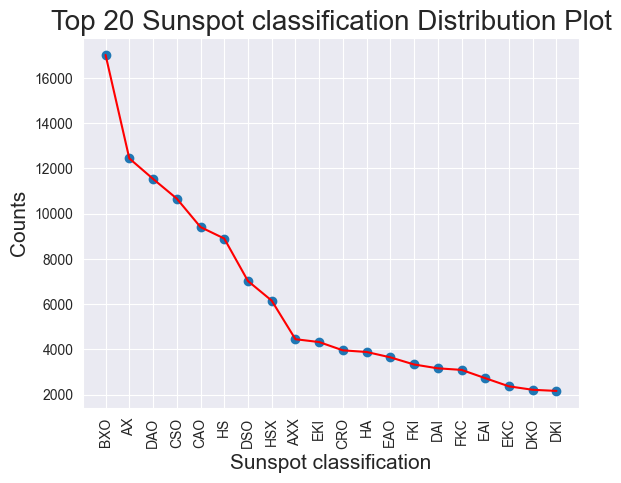

In [34]:
#plot the class distribution
plotter(df, 'class', 'Sunspot Classification')

* The sunspot class with the highest volume of occurence in the merged dataset is BXO with over 160,000 counts. To validate if this is actually true, let me plot the real sunspot data

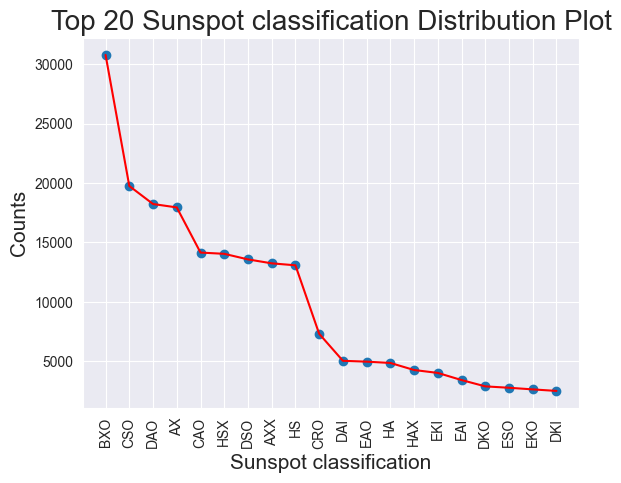

In [35]:
plotter(df1, 'class', 'Sunspot classification')

* Given the similarity of the plot, it is safe to proceed with the analysis

Moving on with the analysis, I want to resample the data into Daily, Weekly, Monthly and Yearly estimates (Sum or Count depending on the datatype of the column).
<br>

So i will use a function to preview each data in terms of the resampling mentioned above, in order to gain insight into the patterns hidden in the data

In [36]:
# using a function perform some analysis ranging from day, week, month, year etc
def dataProcessAnalysis(data, index, col, sample_format, plot_name):
    local_df = data[[index, col]]
    main_df = local_df.set_index(index)
    if main_df[col].dtypes.__str__()[:3] == 'int' or main_df[col].dtypes.__str__()[:5] == 'float':
        sample = main_df.resample(sample_format).sum()
    else:
        sample = main_df.resample(sample_format).count()
    
    form_dict2 = {"Day":"Daily", "Week":"Weekly", "Month":"Monthly", "Year":"Yearly"} 
    form_dict = {"D":"Day", "W":"Week", "M":"Month", "Y":"Year"}
    sample_form = form_dict2.get(form_dict.get(sample_format))    
    
    # prepare the plot figure
    fig = plt.figure(figsize=(15, 8))
    title = plt.title(f"{plot_name.capitalize()} {sample_form} Plot")
    plot = plt.plot(sample[col])
    
    plt.show()
    
    print(f"{form_dict.get(sample_format)} with the highest number of {plot_name}")
    print(sample[sample[col] == sample[col].max()])
    print()
    low = sample[sample[col] == sample[col].min()]
    print(f"First {form_dict.get(sample_format).lower()} with the lowest number of {plot_name}")
    print(low.head(1))
    print()
    print(f"Last {form_dict.get(sample_format).lower()} with the lowest number of {plot_name}")
    print(low.tail(1))



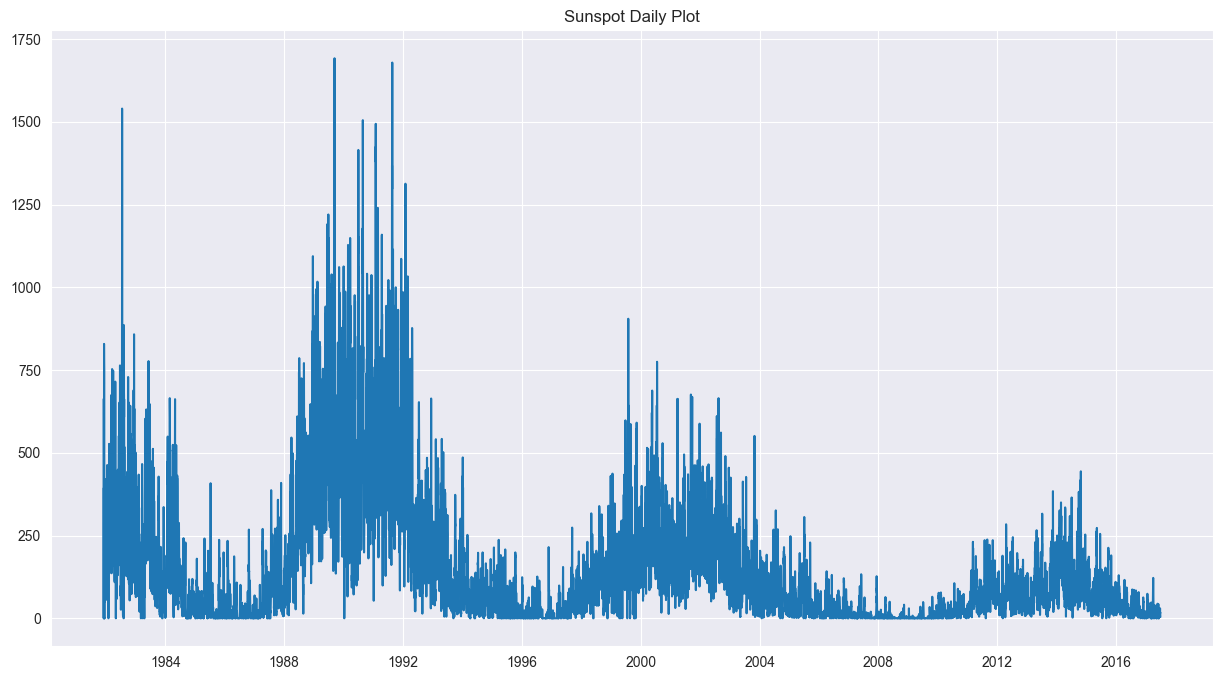

Day with the highest number of Sunspot
              ns
date            
1989-09-10  1692

First day with the lowest number of Sunspot
            ns
date          
1981-12-03   0

Last day with the lowest number of Sunspot
            ns
date          
2017-06-12   0


In [37]:
# Sunspot Daily analysis
dataProcessAnalysis(df1, 'date', 'ns', 'D', 'Sunspot')

From the plot, the daily sunspot shows a wavelength pattern, with highs and lows across the years in review, also to be noted is the date with the highest number of sunspot which happens to be 10th of September, 1989. The significance of this is unknown at this moment, but when the same pattern shows up in the flare type data, the date will definitely have some cues to enable further indepth understanding of the correlation between sunspot and flare occurences.

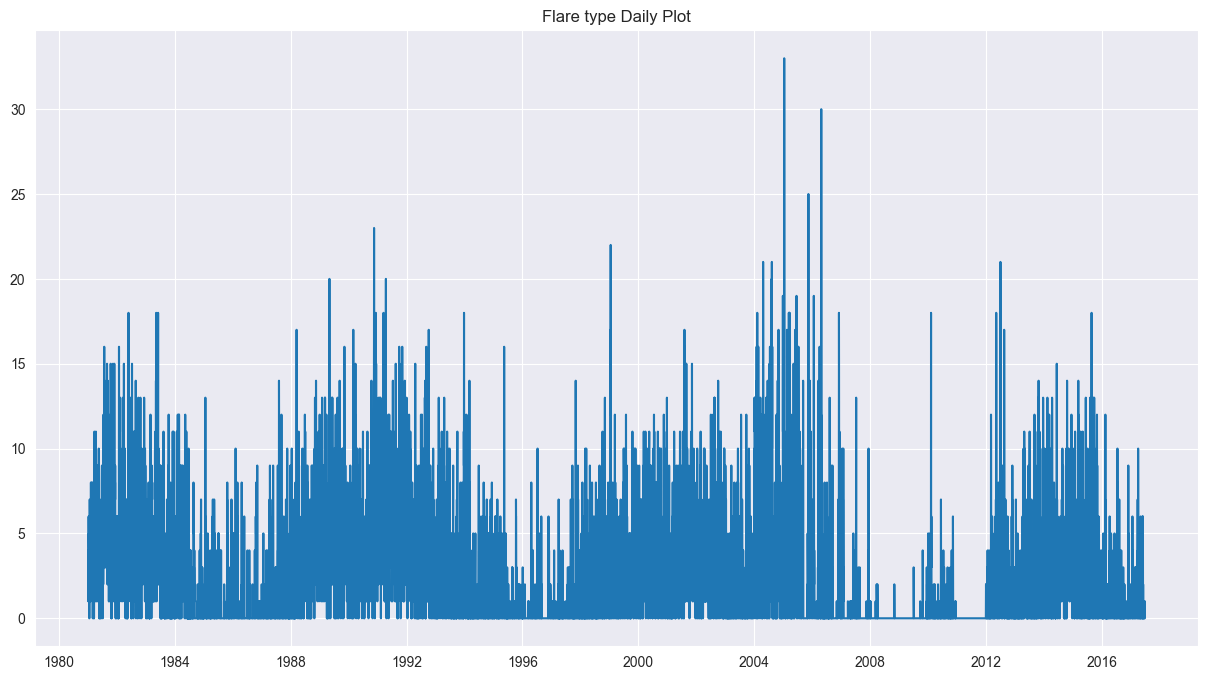

Day with the highest number of Flare type
            flare type
date                  
2005-01-14          33

First day with the lowest number of Flare type
            flare type
date                  
1981-01-16           0

Last day with the lowest number of Flare type
            flare type
date                  
2017-06-26           0


In [38]:
# Flare daily analysis
dataProcessAnalysis(df2, 'date', 'flare type', 'D', 'Flare type')

While the sunspot data showed a wavelength pattern, the flare daily occurences showed no specific pattern, due to the less amount of data in comparison with sunspot.
But a notable observation, showed that 14th of January, 2005 recorded the highest flare occurence in a day. with 33 solar flares for that day. So there is a need to see the types of flares that happened on that day

In [39]:
# day with the highest flare occurence
highest = df2[df2['date'] == '2005-1-14']
highest.head()

,date,flare type,location,NOAA Number
54191,2005-01-14,C10,N16E22,0720
54192,2005-01-14,B86,N16E20,0720
54193,2005-01-14,C14,S06E09,0720
54194,2005-01-14,C93,S06E08,0718
54195,2005-01-14,C10,N15E18,0720


Since we are only interested in M and X class of solar flares, let's filter them out

In [40]:
# X and M class solar flares
x = highest[highest['flare type'].str.startswith('X')]
m = highest[highest['flare type'].str.startswith('M')]

In [41]:
# preview X and M
print(x)
print(m)

Empty DataFrame
Columns: [date, flare type, location, NOAA Number]
Index: []
            date flare type location NOAA Number
54208 2005-01-14        M18   N14E14        0720
54210 2005-01-14        M10   S06E02        0718
54213 2005-01-14        M15   N14E12        0720
54219 2005-01-14        M19   N14E10        0720


While X class of solar flares did not occur on that day, the day recorded 4 different M class solar flares with magnitude ranging from 10 to 19, at different locations on the Sun.

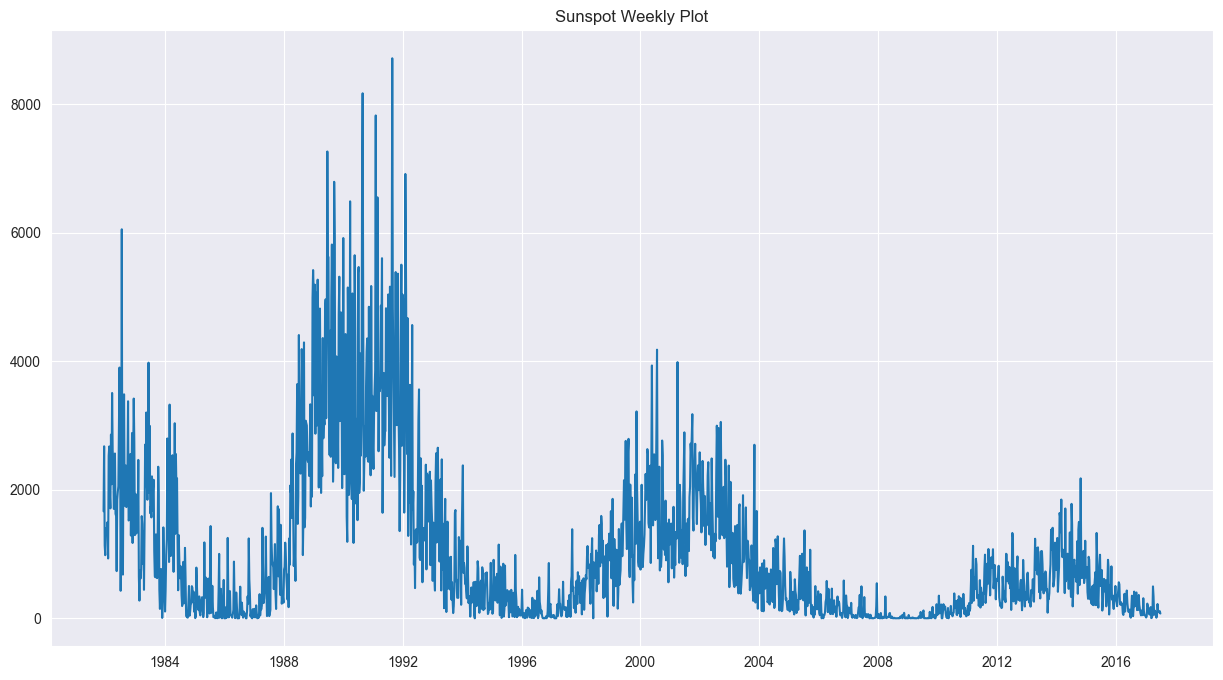

Week with the highest number of Sunspot
              ns
date            
1991-08-25  8717

First week with the lowest number of Sunspot
            ns
date          
1985-12-01   0

Last week with the lowest number of Sunspot
            ns
date          
2010-05-16   0


In [42]:
# Weekly sunspot
dataProcessAnalysis(df1, 'date', 'ns', 'W', 'Sunspot')

Given the plot above, the weekly analysis showed a similar pattern with that of the day analysis, but this time the week with the highest occurences of sunspot is between the third week and the last week of August, 1991.

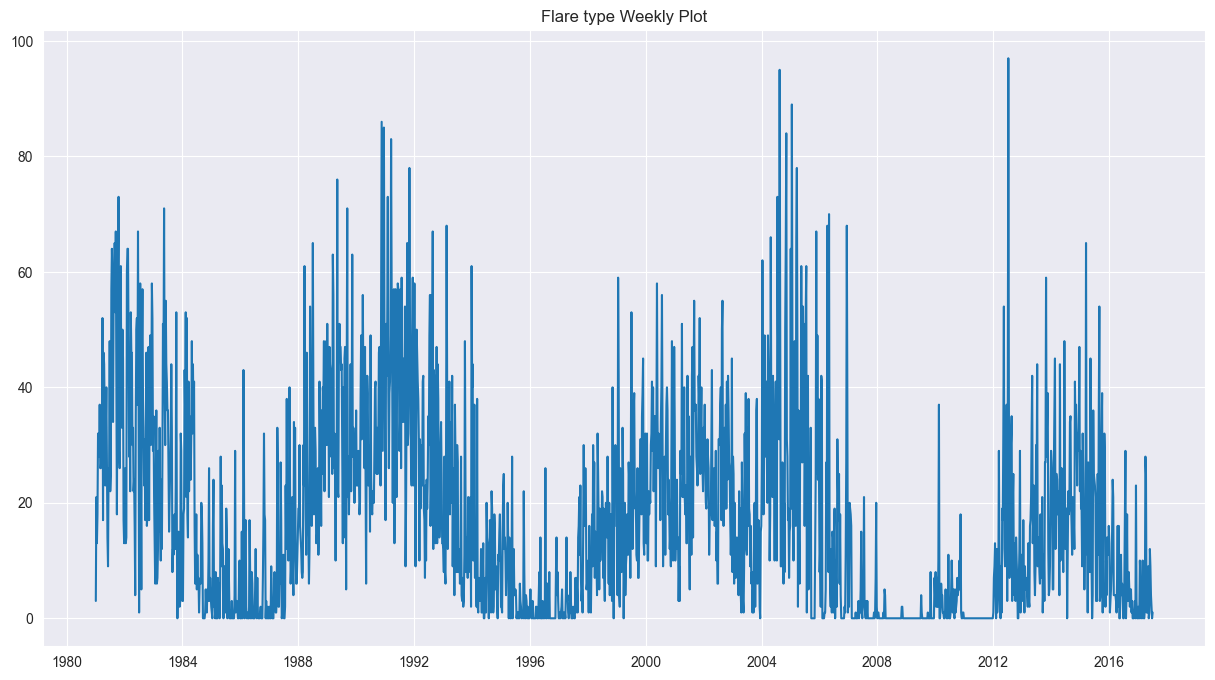

Week with the highest number of Flare type
            flare type
date                  
2012-07-08          97

First week with the lowest number of Flare type
            flare type
date                  
1983-10-30           0

Last week with the lowest number of Flare type
            flare type
date                  
2017-06-25           0


In [43]:
# Weekly flare type
dataProcessAnalysis(df2, 'date', 'flare type', 'W', 'Flare type')

Given the previous daily flare analysis, one would expect that the date will reflect in other resampling, but here we see that the first and second week of July, 2012 had the highest number of occurences in the data in terms of weekly analysis

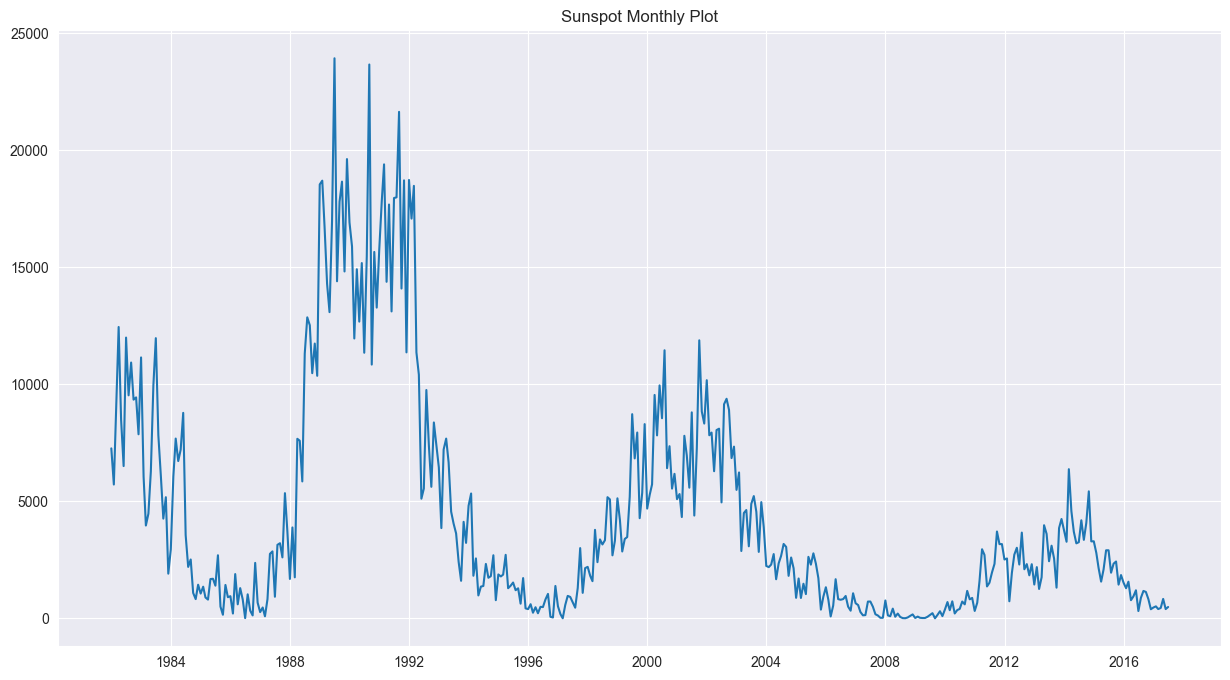

Month with the highest number of Sunspot
               ns
date             
1989-06-30  23922

First month with the lowest number of Sunspot
            ns
date          
1997-02-28   0

Last month with the lowest number of Sunspot
            ns
date          
2009-08-31   0


In [44]:
#monthly sunspot
dataProcessAnalysis(df1, 'date', 'ns', 'M', 'Sunspot')

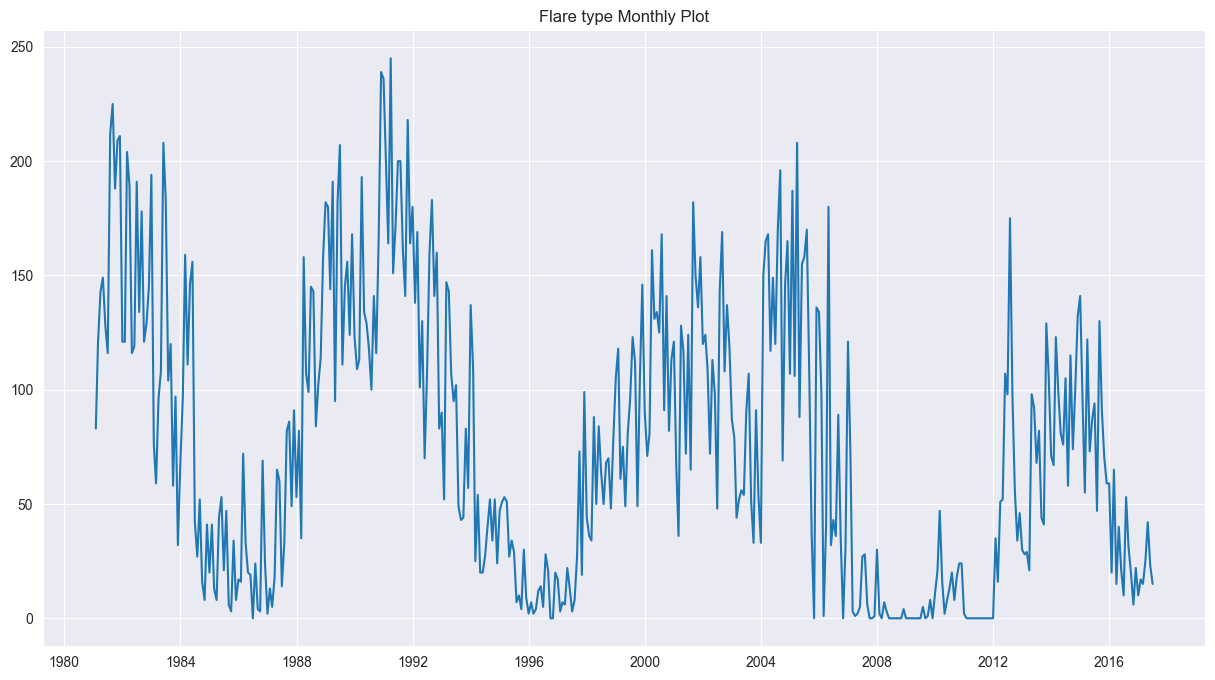

Month with the highest number of Flare type
            flare type
date                  
1991-03-31         245

First month with the lowest number of Flare type
            flare type
date                  
1986-06-30           0

Last month with the lowest number of Flare type
            flare type
date                  
2011-12-31           0


In [45]:
#monthly flare type
dataProcessAnalysis(df2, 'date', 'flare type', 'M', 'Flare type')

The monthly analysis of both the sunspot and solar flares showed that the 1980s had the highest number of solar irregularities recorded in the years in review, while the sunspot occured in the month of June, 1989, the flares occured in February, of 1982.
At this moment no conclusion can be reached due to insufficiency of data to draw further inferences from, in relation to these dates.

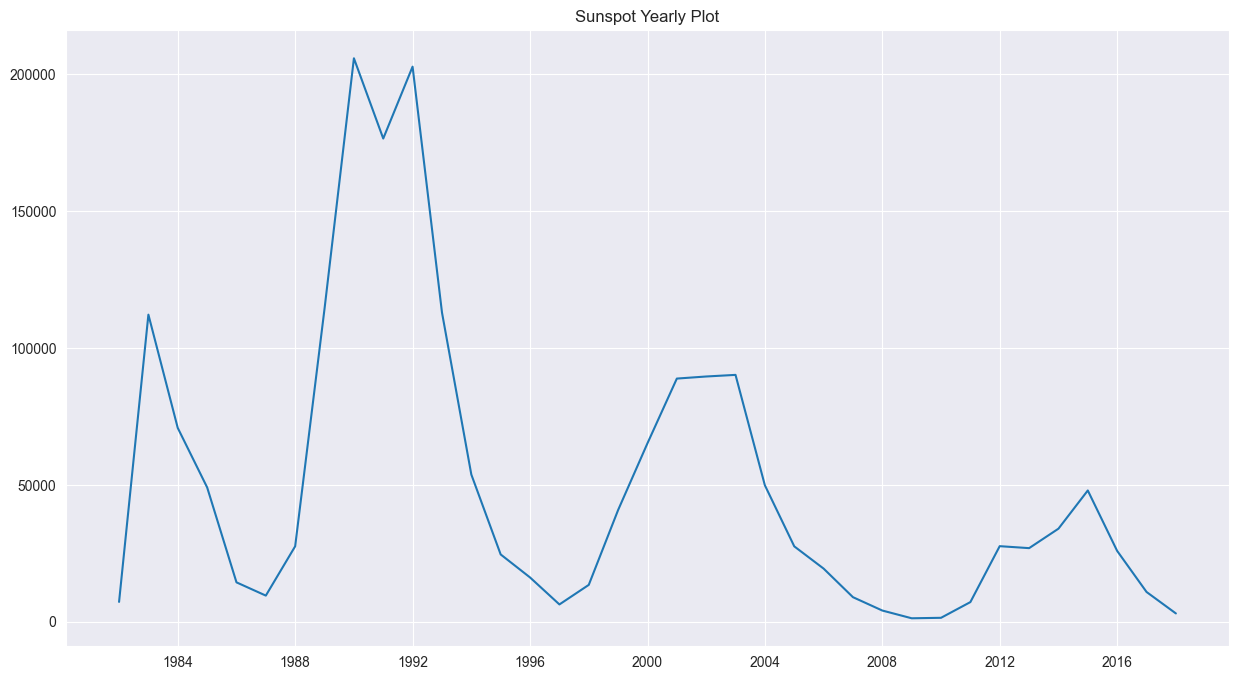

Year with the highest number of Sunspot
                ns
date              
1989-12-31  205876

First year with the lowest number of Sunspot
              ns
date            
2008-12-31  1275

Last year with the lowest number of Sunspot
              ns
date            
2008-12-31  1275


In [46]:
# Yearly sunspot
dataProcessAnalysis(df1, 'date', 'ns', 'Y', 'Sunspot')

The same year with the highest number of sunspot while reviewing the monthly analysis also happened to be the year with the highest number of sunspot, across the years in review.

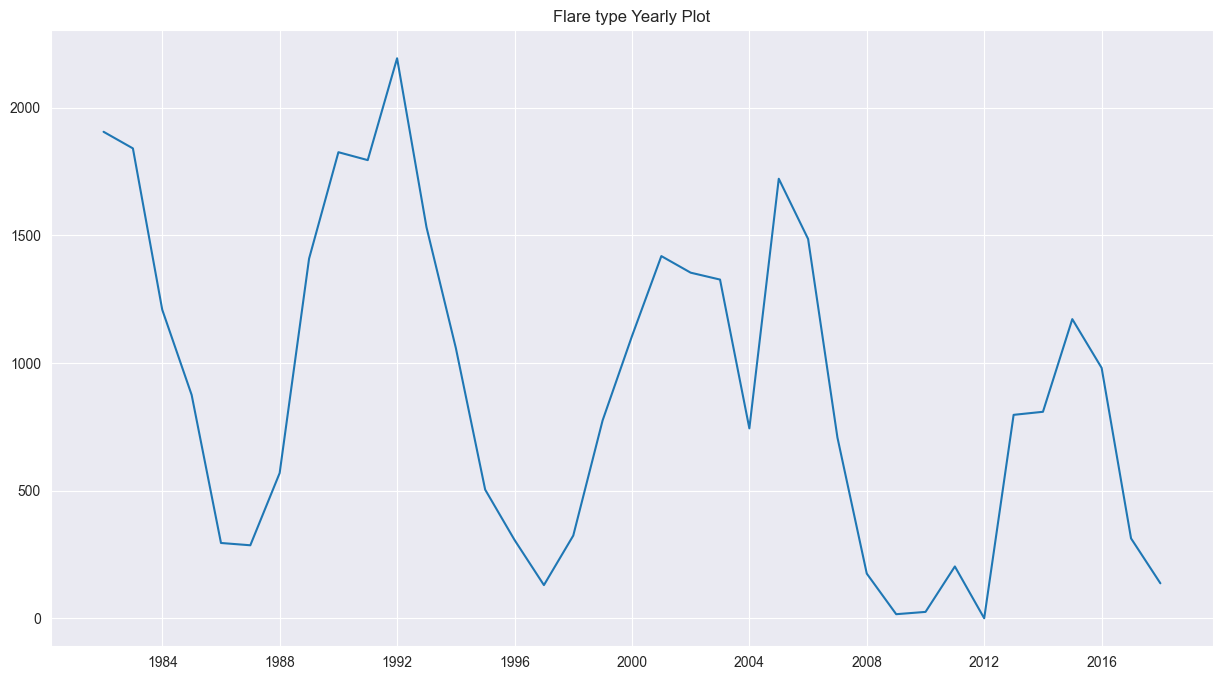

Year with the highest number of Flare type
            flare type
date                  
1991-12-31        2194

First year with the lowest number of Flare type
            flare type
date                  
2011-12-31           0

Last year with the lowest number of Flare type
            flare type
date                  
2011-12-31           0


In [47]:
#Yearly Flare type
dataProcessAnalysis(df2, 'date', 'flare type', 'Y', 'Flare type')

Since the 1980's had both the highest monthly and yearly occurences of sunspot and solar flares, let's examine the M and X class of solar flares in that decade.

In [48]:
# decade with the highest sunspot and flares
df4 = df2.copy()
df4['year'] = df2['date'].dt.strftime("%Y")
df4['year'] = df4['year'].astype('object')
decade = df4[df4['year'].str.startswith('198')]
decade

,date,flare type,location,NOAA Number,year
6,1981-01-03,C12,S05W67,2857,1981
7,1981-01-03,C20,N14W78,2866,1981
11,1981-01-04,C22,N11W86,2872,1981
16,1981-01-05,C18,S14E47,2875,1981
23,1981-01-06,C25,S17E39,2875,1981
...,...,...,...,...,...
20977,1989-12-30,X10,S19E09,5858,1989
20978,1989-12-30,C88,S18E10,5858,1989
20979,1989-12-31,C41,S17E03,5858,1989
20980,1989-12-31,X28,S25W51,5852,1989


In [49]:
# select the X and M class
x = decade[decade['flare type'].str.startswith('X')]
m = decade[decade['flare type'].str.startswith('M')]

In [50]:
#print the result
x.value_counts()

date        flare type  location  NOAA Number  year
1981-02-17  X10         N20W20    2941         1981    1
1989-01-13  X23         S31W05    5312         1989    1
1989-01-14  X21         S32W10    5312         1989    1
1989-01-18  X14         S30W65    5312         1989    1
1989-01-27  X11         S19E17    5330         1989    1
                                                      ..
1982-07-12  X71         N11E37    3804         1982    1
1982-07-17  X32         N14W32    3804         1982    1
1982-07-19  X12         N20W45    3804         1982    1
1982-11-12  X11         S11E33    3987         1982    1
1989-12-31  X28         S25W51    5852         1989    1
Length: 148, dtype: int64

To understand the table more, i will plot the yearly report of the X class of solar flares

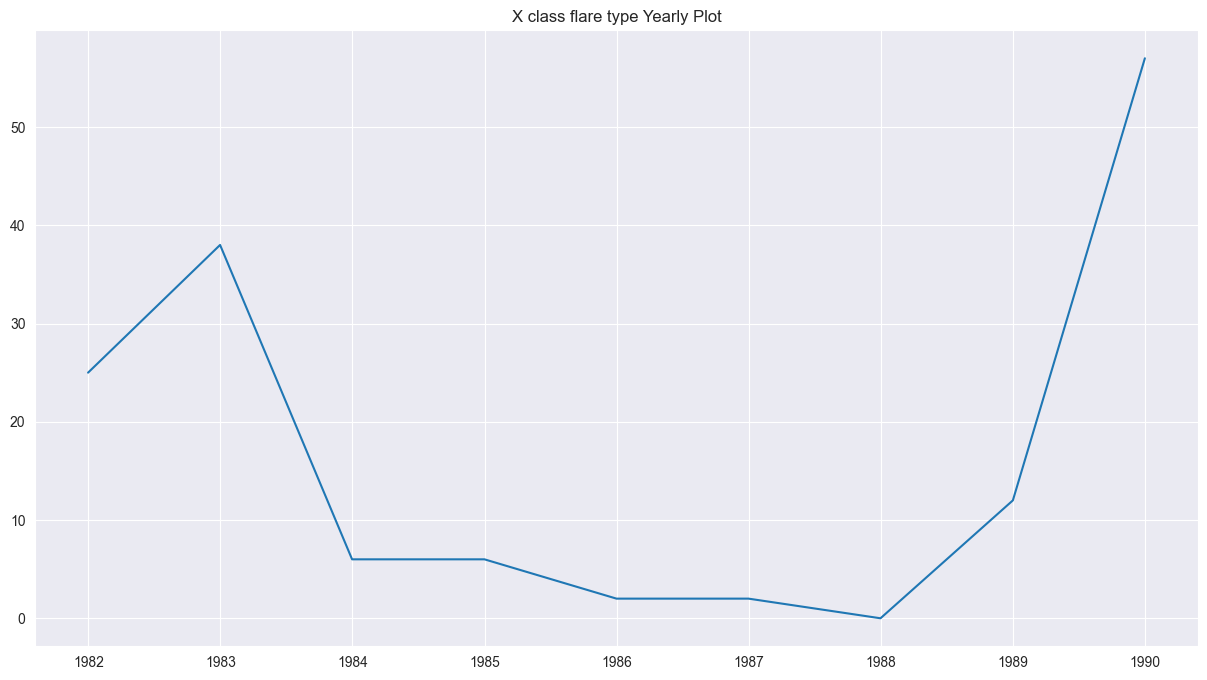

Year with the highest number of X class flare type
            flare type
date                  
1989-12-31          57

First year with the lowest number of X class flare type
            flare type
date                  
1987-12-31           0

Last year with the lowest number of X class flare type
            flare type
date                  
1987-12-31           0


In [51]:
#Yearly X class Flare type
dataProcessAnalysis(x, 'date', 'flare type', 'Y', 'X class flare type')

Here the X class flare type occured 57 times in 1989, this is a massive discovery, as this coincides with the year the first GPS satellite went up into space.
Could it be possible that our interest in the solar atmosphere, triggered more solar flares or just coincidence?
This report is not going to show that, as this requires more data to make any real hypothesis to that effect.

In [52]:
# preview the M class
m

,date,flare type,location,NOAA Number,year
116,1981-01-25,M12,N18W26,2907,1981
123,1981-01-25,M24,S13E75,2911,1981
124,1981-01-25,M13,S13E90,2911,1981
132,1981-01-25,M19,S15E95,2911,1981
133,1981-01-26,M26,S14E84,2911,1981
...,...,...,...,...,...
20972,1989-12-29,M28,S19E18,5858,1989
20973,1989-12-29,M97,S19E21,5858,1989
20974,1989-12-29,M28,S27W33,5852,1989
20975,1989-12-29,M22,S27W34,5852,1989


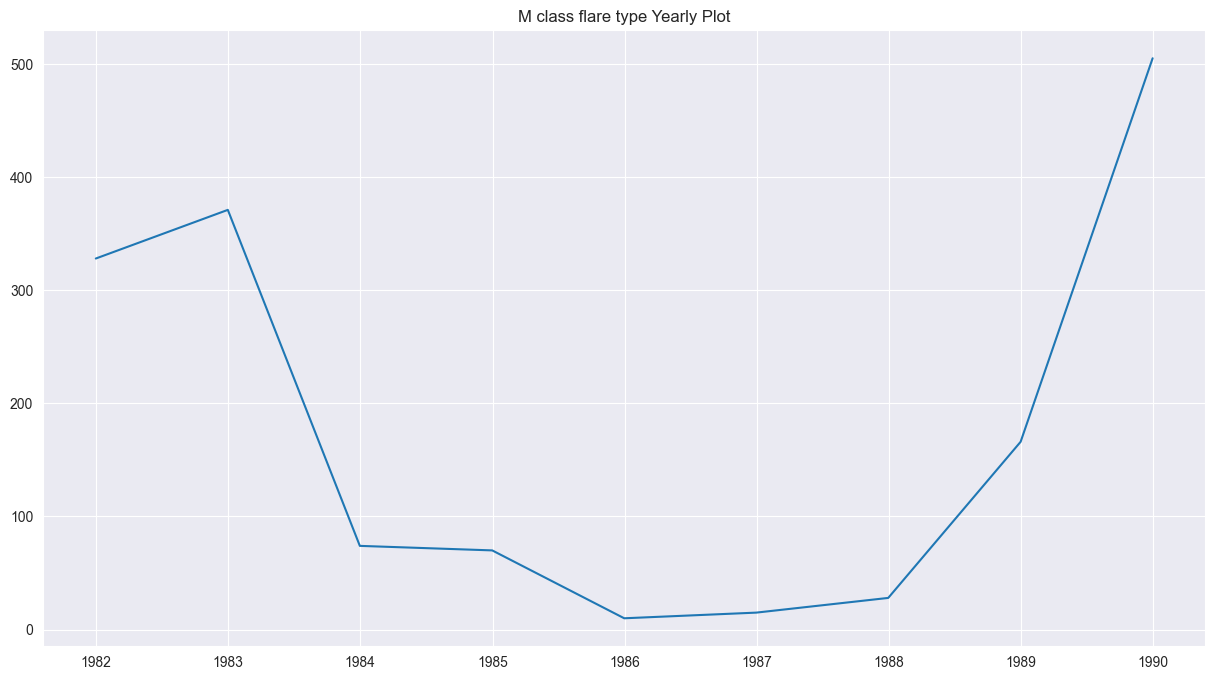

Year with the highest number of M class flare type
            flare type
date                  
1989-12-31         505

First year with the lowest number of M class flare type
            flare type
date                  
1985-12-31          10

Last year with the lowest number of M class flare type
            flare type
date                  
1985-12-31          10


In [53]:
#Yearly M class Flare type
dataProcessAnalysis(m, 'date', 'flare type', 'Y', 'M class flare type')

The same year had over 505 M class solar flares.

### <center> CORRELATION BETWEEN SUNSPOT DATA AND SOLAR FLARES </center>

To enable extensive analysis, I will use a function to visualize the correlation between sunspot and solar flares

In [54]:
#Correlation plotting function
def correlationPlot(data1, col1, col1_name, data2, col2, col2_name, index, sample_format):
    #first dataset
    local_df1 = data1[[index, col1]]
    main_df1 = local_df1.set_index(index)
    
    #second dataset
    local_df2 = data2[[index, col2]]
    main_df2 = local_df2.set_index(index)
    
    #set the parameter for tabulating the column
    if main_df1[col1].dtypes.__str__()[:3] == 'int' or main_df1[col1].dtypes.__str__()[:5] == 'float':
        sample1 = main_df1.resample(sample_format).sum()
    else:
        sample1 = main_df1.resample(sample_format).count()
    
    if main_df2[col2].dtypes.__str__()[:3] == 'int' or main_df2[col2].dtypes.__str__()[:5] == 'float':
        sample2 = main_df2.resample(sample_format).sum()
    else:
        sample2 = main_df2.resample(sample_format).count()
    
    #dict for the resample format
    form_dict2 = {"Day":"Daily", "Week":"Weekly", "Month":"Monthly", "Year":"Yearly"} 
    form_dict = {"D":"Day", "W":"Week", "M":"Month", "Y":"Year"}
    sample_form = form_dict2.get(form_dict.get(sample_format))
    
    # prepare the plot figure
    fig = plt.figure(figsize=(15, 8))
    title = plt.title(f"Correlation between {col1_name.capitalize()} and {col2_name.capitalize()} {sample_form} Plot")
    plot = plt.plot(sample1[col1])
    plot2 = plt.plot(sample2[col2])
    y_scale = plt.yscale('log')
    plt.show()

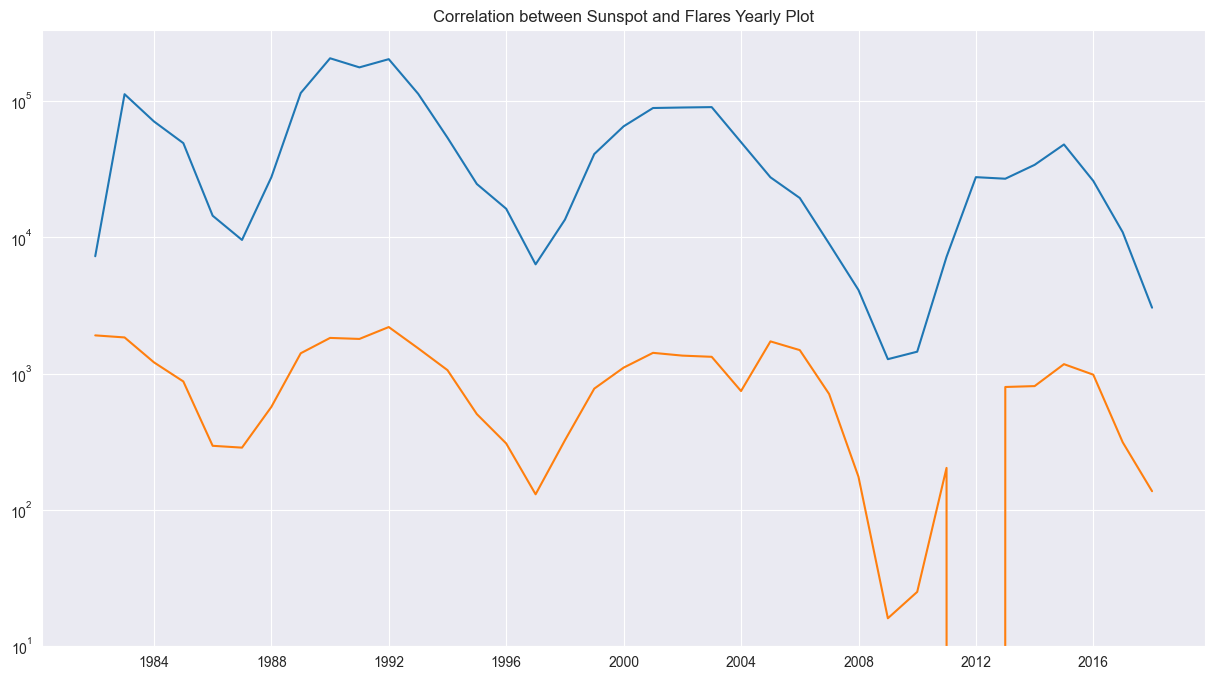

In [55]:
#Extract the year, and plot the correlation between the two dataset
correlationPlot(df1, 'ns', 'Sunspot', df2, 'flare type', 'Flares', 'date', 'Y')

* From the Yearly plot of the correlation between sunspot and solar flares, there is a close linear relationship between sunspot and solar flares, although this is not conclusive yet, nevertheless, an increase in sunspot depicts an increase in solar flares, but the exact degree of increase is unknown at this moment.
<br>

Let's look at other analysis to determine the validity of the observation made here

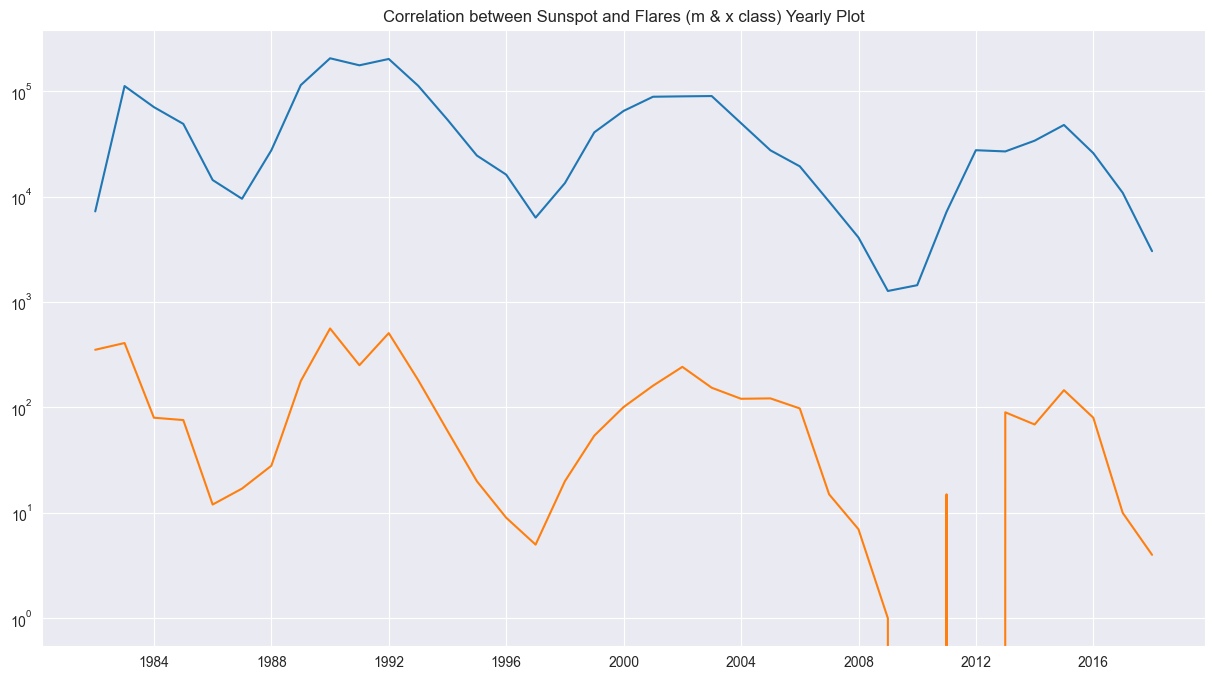

In [56]:
#Extract the year, and plot the correlation between the sunspot dataset and the M and X flare types dataset
correlationPlot(df1, 'ns', 'Sunspot', flares, 'flare type', 'Flares (M & X Class)', 'date', 'Y')

The X and M class of solar flares plot is very similar to the the sunspot/solar flares plot. So there is no much detail available here. 

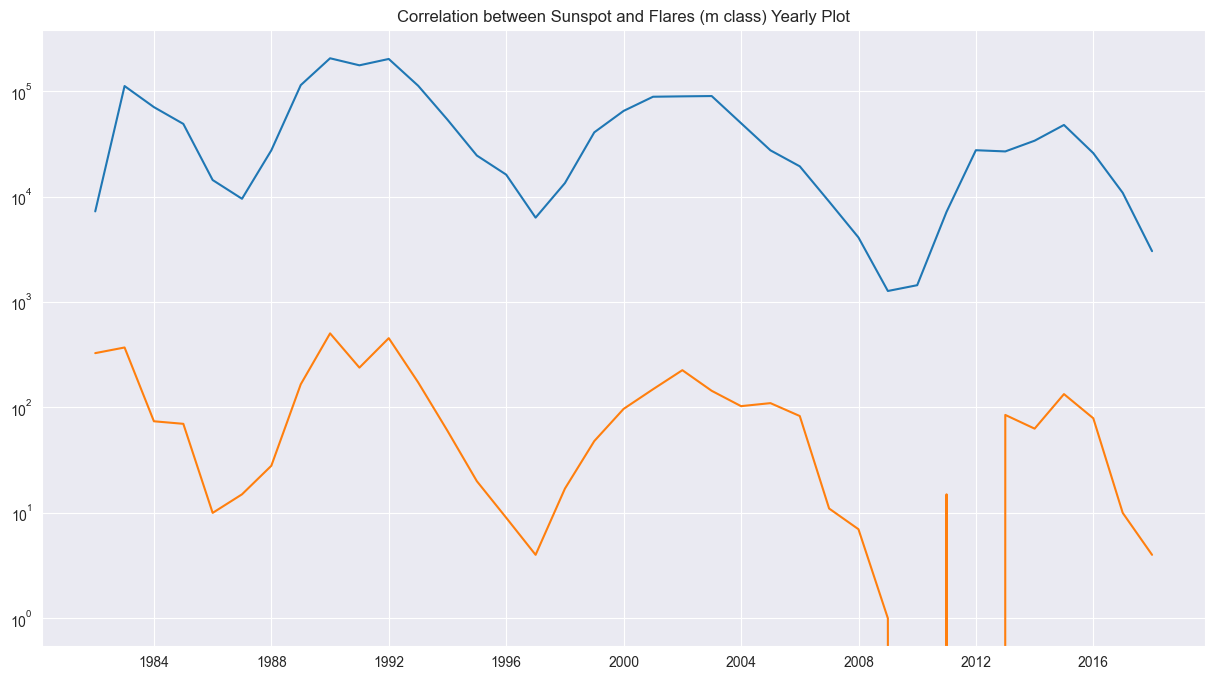

In [57]:
#Extract the year, and plot the correlation between the sunspot dataset and the M flare types dataset
correlationPlot(df1, 'ns', 'Sunspot', m_flares, 'flare type', 'Flares (M Class)', 'date', 'Y')

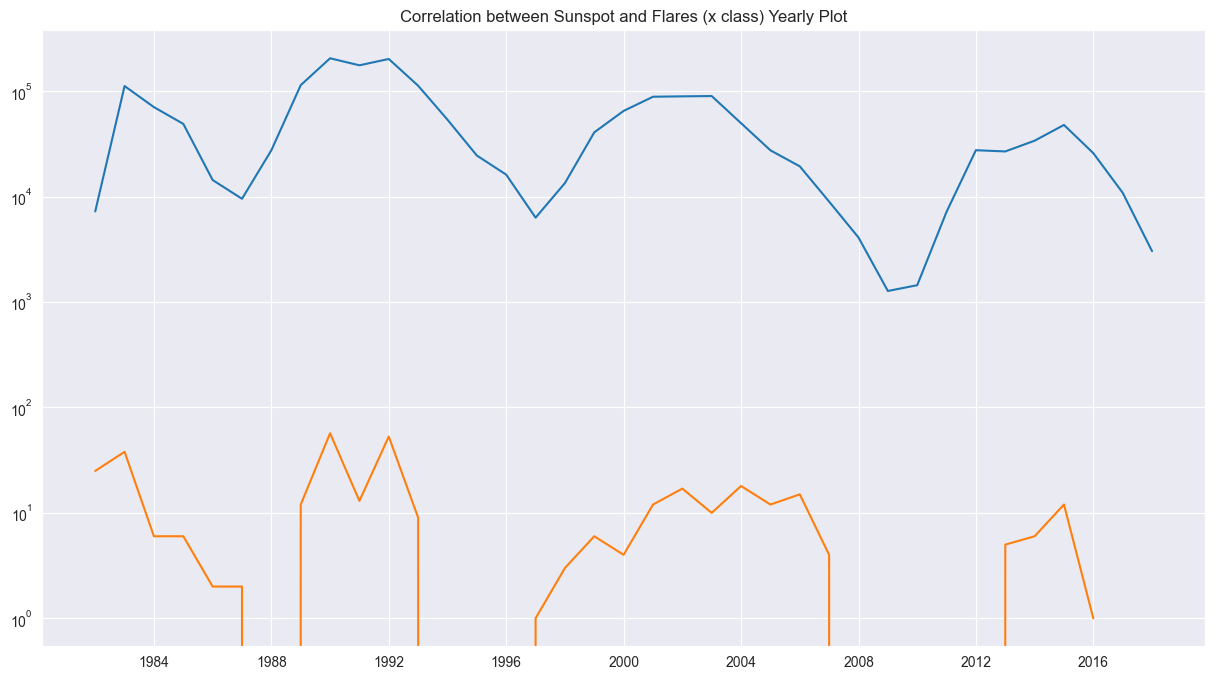

In [58]:
#Extract the year, and plot the correlation between the sunspot dataset and the X flare types dataset
correlationPlot(df1, 'ns', 'Sunspot', x_flares, 'flare type', 'Flares (X Class)', 'date', 'Y')

While the M class was closely similar to the X and M class, the X class alone is showing a disjointed pattern of X class flares, where each group has a start and end with breaks in-between them.
* First break is noticed during the year 1988
* Second break from 1994 to 1997
* Third break from 2008 to 2010
* Fourth break from 2016
<br>

Apart from the first break, other breaks showed atleast two years where no X class of solar flares occured.

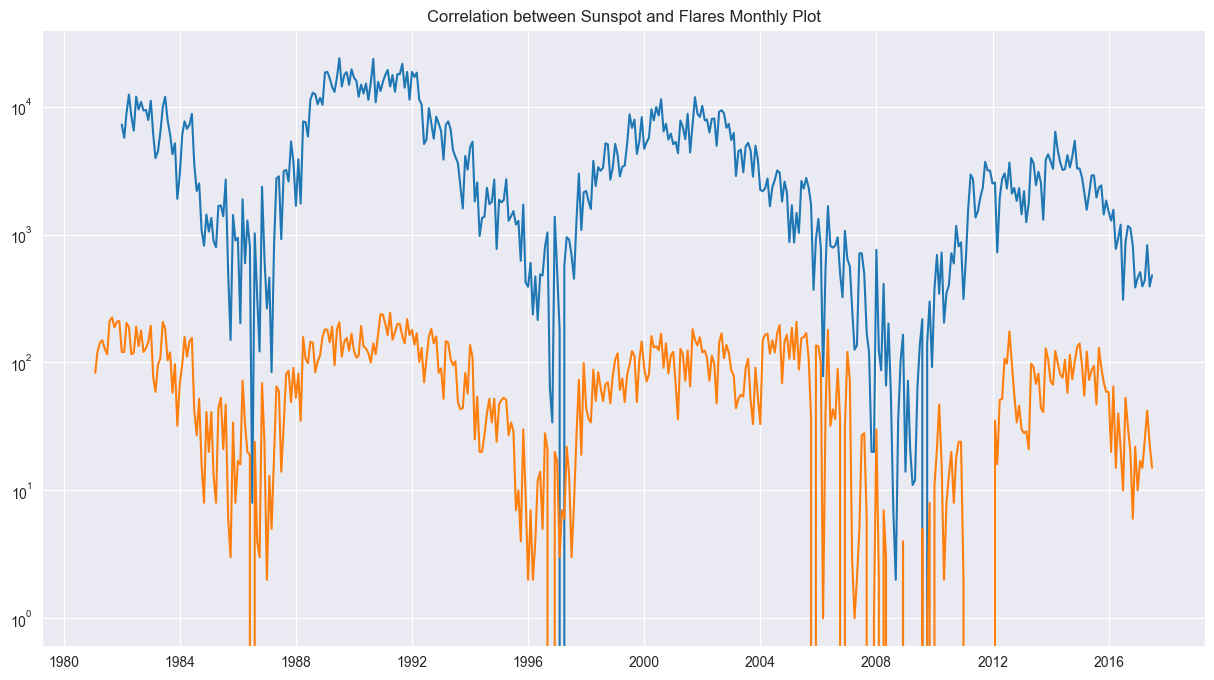

In [59]:
#Extract the month, and plot the correlation between the two dataset
correlationPlot(df1, 'ns', 'Sunspot', df2, 'flare type', 'Flares', 'date', 'M')

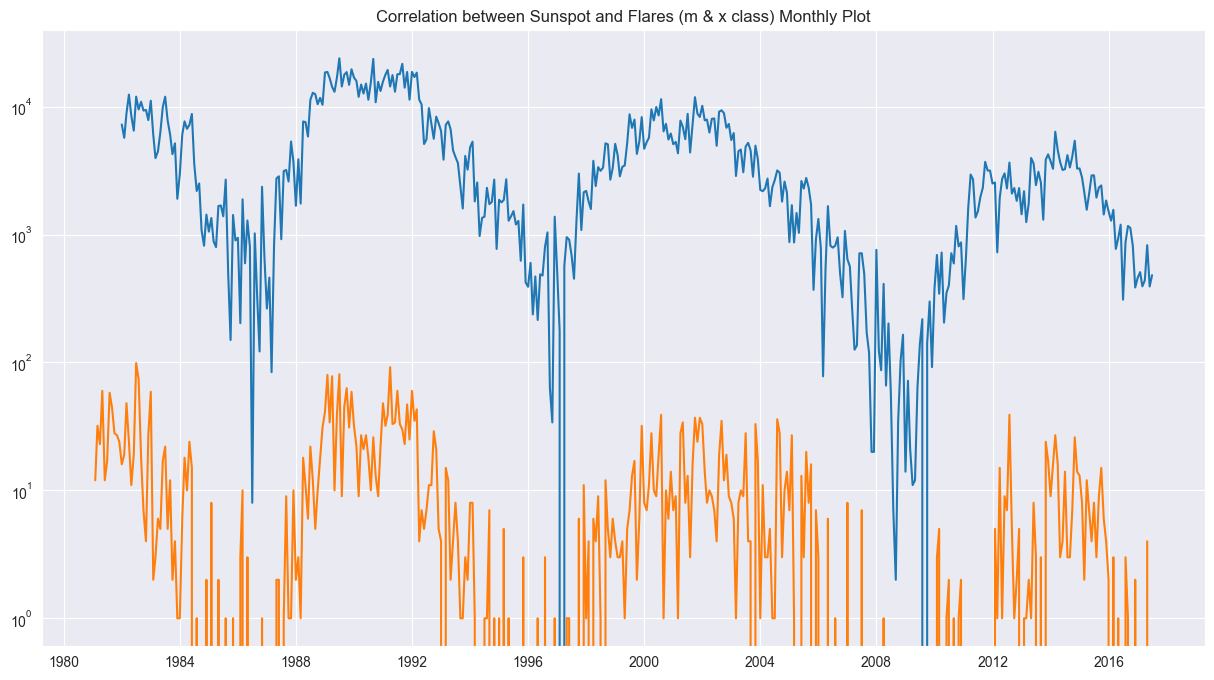

In [60]:
#Extract the month, and plot the correlation between the sunspot dataset and the M and X flare types dataset
correlationPlot(df1, 'ns', 'Sunspot', flares, 'flare type', 'Flares (M & X Class)', 'date', 'M')

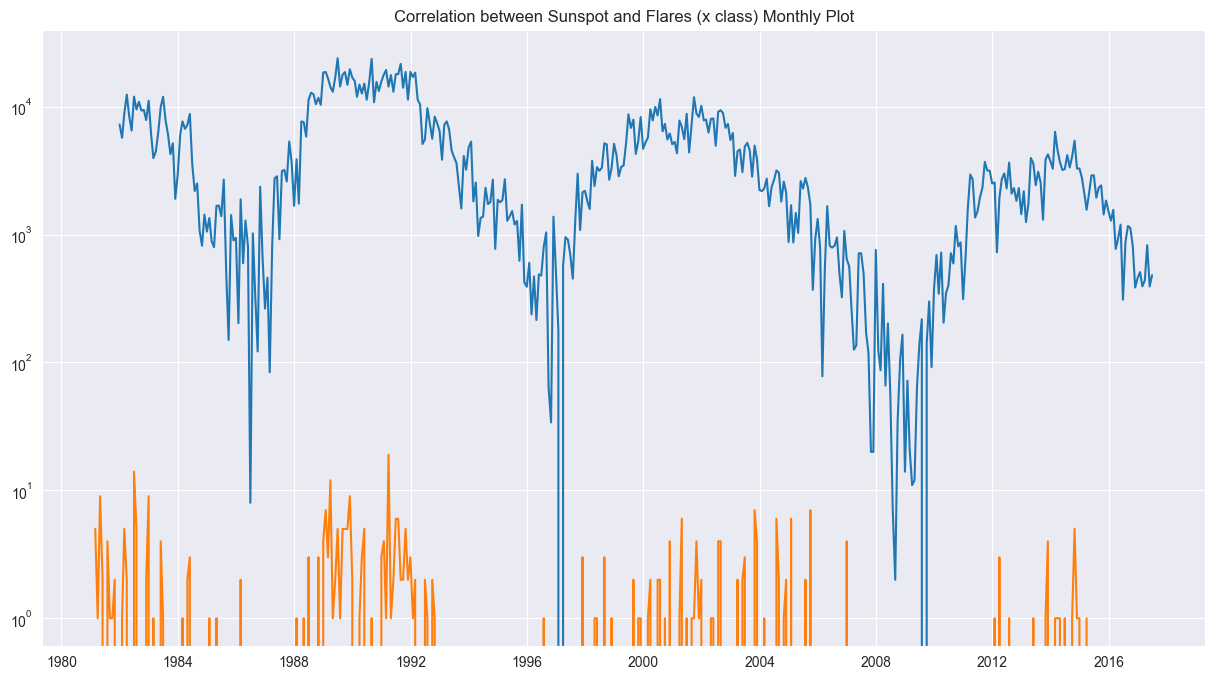

In [61]:
#Extract the month, and plot the correlation between the sunspot dataset and the X flare types dataset
correlationPlot(df1, 'ns', 'Sunspot', x_flares, 'flare type', 'Flares (X Class)', 'date', 'M')

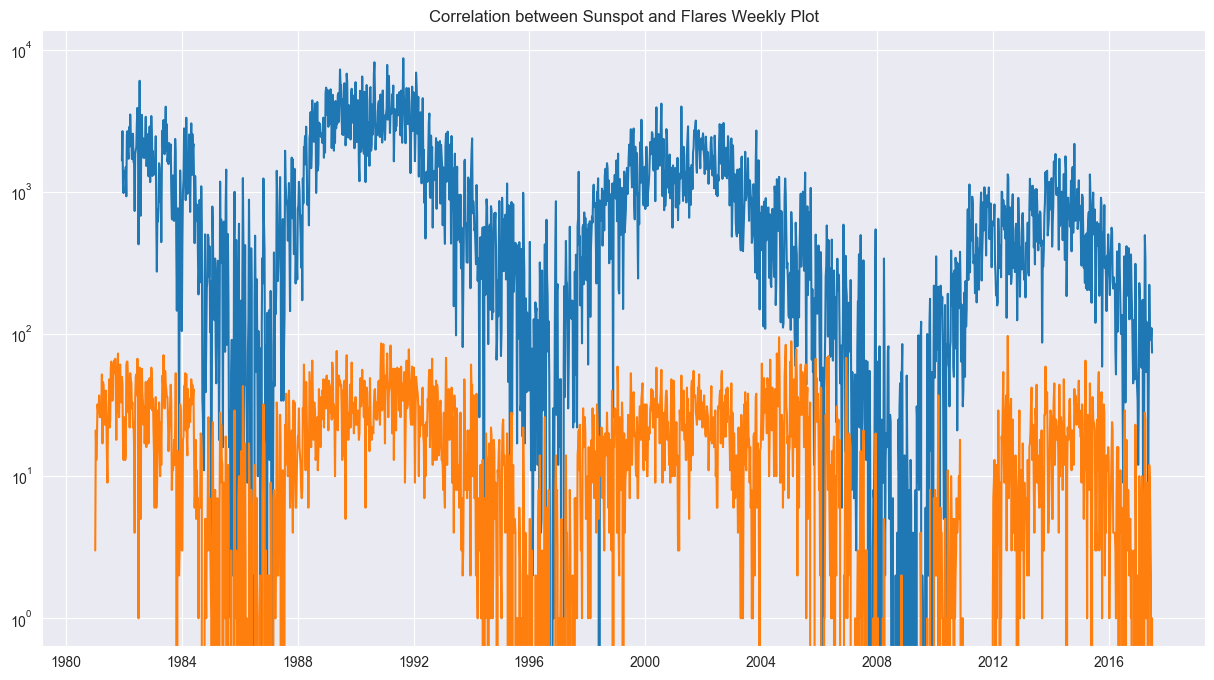

In [62]:
#Extract the week, and plot the correlation between the two dataset
correlationPlot(df1, 'ns', 'Sunspot', df2, 'flare type', 'Flares', 'date', 'W')

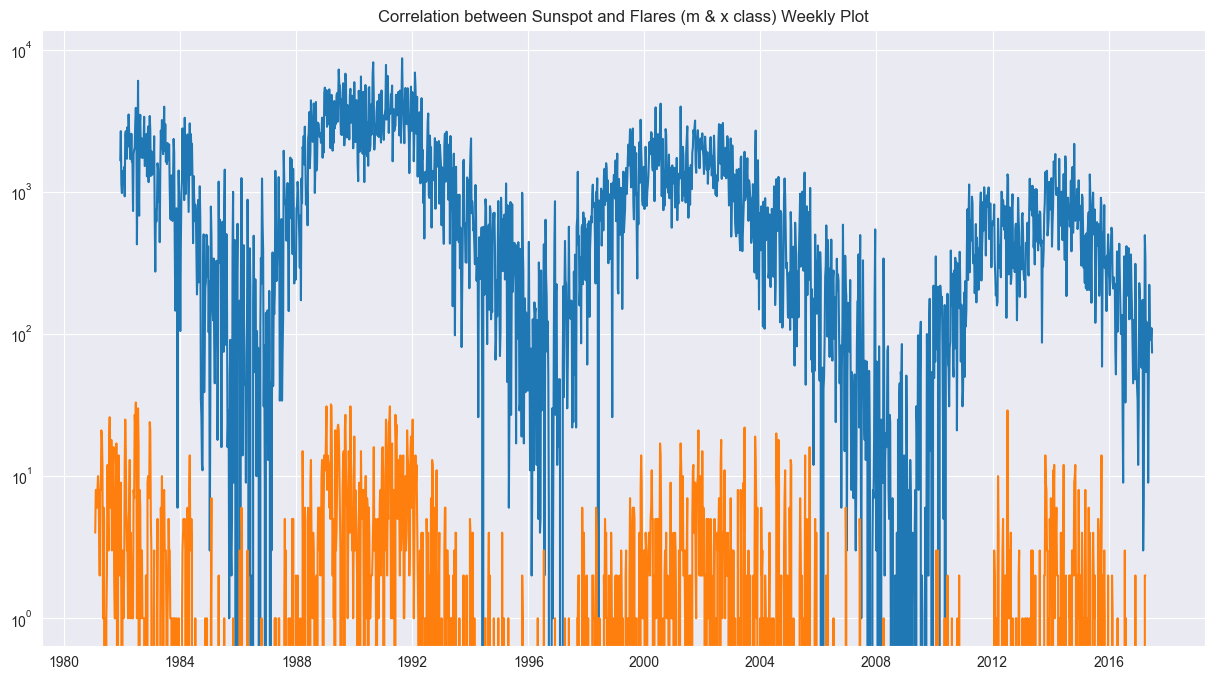

In [63]:
#Extract the week, and plot the correlation between the sunspot dataset and the M and X flare types dataset
correlationPlot(df1, 'ns', 'Sunspot', flares, 'flare type', 'Flares (M & X Class)', 'date', 'W')

The monthly and weekly plots agrees with the yearly analysis, to depict a close to linear relationship between sunspot and solar flares.
So an increase in sunspot occurences could lead to a lesser degree increase in solar flares.

### <center> CONCLUSION </center>

* I was unable to use the location column because the GoogleMap API requires authentication token to use it. But majority of the analysis was focused on hidden patterns in the two datasets
* The monthly analysis of both the sunspot and solar flares showed that the 1980s had the highest number of solar irregularities recorded in the years in review
* The highest occurences of X class solar flares happened 57 times in 1989 and that same year head 505 M class solar flares occurences.
* After visualizing the correlation between sunspot and solar flares, there is a close linear relationship between sunspot and solar flares, whereby an increase in sunspot depicts an increase in solar flares, but the exact degree of increase is not known.
* The X class solar flares showed a distinction of start and end periods with breaks in-between, which led to a distinct four breaks (1988, 1994-1997, 2008-2010 and 2016-2017 which is the end of the data)
* After visually analyzing the monthly and weekly reports, the analysis showed a close to linear relationship between sunspot and solar flares. So an increase in sunspot could lead to a lesser degree increase in solar flares.

### <center> RECOMMENDATION </center>

* Given the nature of the dataset, more research is needed to help develop techniques that will reduce the amount of missing data in the dataset.
* From the report, more research is needed to further understand to what degree of accuracy, an increase in sunspot can lead to solar flares